In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [2]:
final_result = np.load('schf_fixed_u_filling_0p5_t_4_em4_random_basis_mesh_60_pmap_over_v1_v2.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u = final_result['u']
v1_arr = final_result['v1']
v2_arr = final_result['v2']
v1_mesh, v2_mesh = np.meshgrid(v1_arr, v2_arr, indexing = 'ij')

In [3]:
np.max(final_c_difference)

np.float64(1.203919981207502e-07)

In [4]:
np.max(final_e_difference)

np.float64(9.9620445503934e-09)

In [5]:
np.all(any_bi_fail)==False

np.True_

### Phase Analysis

In [6]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_bond = np.take_along_axis(final_bond, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)

In [7]:
from functions_parameters.universal_parameters import phase_1_1, threshold, c_6_uc, c_3_uc, c_2_uc
from functions_parameters.tools import phase_check_nematic_magnetic

phase_diagram_based_on_d = np.zeros(v1_mesh.shape)
nematic_measure = np.zeros(v1_mesh.shape)
f_phase = np.zeros(v1_mesh.shape)
f_measure = np.zeros(v1_mesh.shape)
f_max_measure = np.zeros(v1_mesh.shape)
for i in range(v1_mesh.shape[0]):
    for j in range(v1_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_o, c_6_uc, c_3_uc, c_2_uc)
        phase_arr = np.kron(rs_recording,m_recording)
        nematic_measure[i,j] = c6_diff
        f_phase[i,j] = np.argmax(m_recording)
        f_measure[i,j] = np.mean(np.abs(magnetism_arr))
        f_max_measure[i,j] = np.max(np.abs(magnetism_arr))
        phase = np.argmax(phase_arr)
        phase_diagram_based_on_d[i,j]=phase

unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_1_1[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(v1_mesh.shape[0]):
    for j in range(v1_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1, u=0.75')

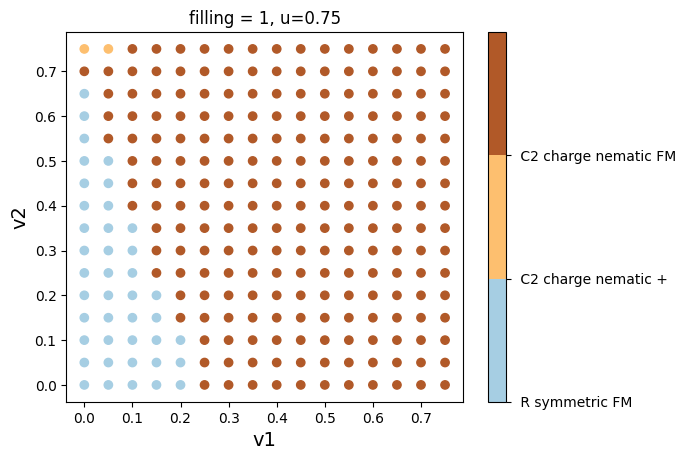

In [8]:
colorbar_ticks_combined = np.arange(len(unique_phase_index))
cmap = plt.get_cmap("Paired", len(unique_phase_index))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(v1_mesh, v2_mesh, c=filtered_phase_diagram, cmap=cmap,vmin=0, vmax=len(unique_phase_index))
# plt.xlabel(r'$E_{f}$', size = '14')
plt.xlabel('v1', size = '14')
plt.ylabel('v2', size = '14')
# plt.xlim(3.8,6)
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1, u=%s'%u[0])

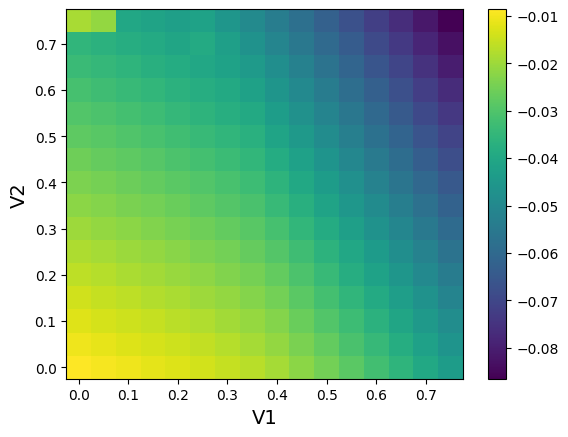

In [9]:
plt.pcolormesh(v1_mesh,v2_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V1', size = '14')
plt.ylabel('V2', size = '14')
plt.colorbar()

In [10]:
np.mean(final_iteration)

np.float64(55.382421875)

In [11]:
np.max(final_iteration)

np.int32(500)

In [12]:
np.min(final_iteration)

np.int32(4)

# Single point check for scattering points.

In [13]:
import jax
import jax.numpy as jnp
import numpy as np
import os
from itertools import product

from functions_parameters.jax_schf_kernel import schf_fixed_filling_pmap_over_u, schf_single_job
from functions_parameters.jax_schf_helpers import *
from functions_parameters.universal_parameters import a, b
from functions_parameters.bond_table_generator import build_buckets_per_shell

# ---- numeric mode ----
from jax import config as _jax_config
_jax_config.update("jax_enable_x64", True)  # use float64 by default

Array = jnp.ndarray
PyTree = Any

'''
preparation:
'''
# order is important. for sublattice a, b and c respectively
basis_frac = np.array([[1/2, 0], [1/2, 1/2], [0, 1/2]])
norb = basis_frac.shape[0]
num_k_mesh = 60
b_0 = np.linspace(-b[0] / 2, b[0] / 2, num_k_mesh, endpoint=False)
b_1 = np.linspace(-b[1] / 2, b[1] / 2, num_k_mesh, endpoint=False)
k_mesh_points = np.vstack([v1 + v2 for v1, v2 in product(b_0, b_1)])
num_k_points = k_mesh_points.shape[0]

radii, a_lists, deltas = build_buckets_per_shell(a, basis_frac, 2)

# in this case, as both TB model and interaction, we include up to NNN, the a_list and deltas are the same
# calculate the correlation matrix
temperature = 4E-4
# filling has to be 4 times before, as we have 4 unit cells in the 2x2 square lattice
filling = 1/4
mu = 2
t_nn = 1
t_nnn = -0.025
t_arr = np.array([t_nn, t_nnn])

phase_pos, phase_neg = precompute_k_phase_tables(deltas, a, k_mesh_points)
Htb, e_all, v_all, v_all_dagger = hk_all_k_from_phases(mu, a_lists, t_arr, phase_neg)
dict_ref = prepare_reference_state(filling, a_lists, Htb, e_all, v_all, v_all_dagger, phase_pos, phase_neg, temperature)

u_arr = jnp.array([0.75])
Htb = jnp.stack((jnp.asarray(Htb), jnp.asarray(Htb)), axis=1)
filling = filling * 2
a_lists = jnp.asarray(a_lists)
phase_pos = jnp.asarray(phase_pos)
phase_neg = jnp.asarray(phase_neg)

### interchange (1,-1), (2,-1)

In [14]:
v1_index_input = 2
v2_index_input = -1
input_d = sorted_density[v1_index_input,v2_index_input,0]
input_bond = sorted_bond[v1_index_input,v2_index_input,0]

v1_index = 1
v2_index = -1
v1_arr_input = jnp.array([v1_arr[v1_index]])
v2_arr_input = jnp.array([v2_arr[v2_index]])
v_arr = jnp.concatenate([v1_arr_input, v2_arr_input])
nshell = v_arr.shape[0]
ndeltas = deltas.shape[0]

res_1_m1 = schf_single_job(Htb, a_lists, phase_pos, phase_neg, dict_ref, input_d, input_bond, filling, u_arr, v_arr, temperature)

In [15]:
input_d

array([[1.47936896e-01+1.12434520e-26j, 2.04126208e-01-5.67819710e-20j,
        1.47936896e-01+7.04267794e-21j],
       [8.75651076e-27-1.74151231e-50j, 8.75651076e-27-6.62735963e-45j,
        8.75651076e-27+3.29913119e-46j]])

In [16]:
v_arr

Array([0.05, 0.75], dtype=float64)

In [17]:
res_1_m1['gse'],res_1_m1['c_diff'],res_1_m1['e_diff']

(Array([-0.03873877], dtype=float64),
 Array(9.39281236e-08, dtype=float64),
 Array(2.66636435e-10, dtype=float64))

In [18]:
res_1_m1['d']

Array([[1.50980048e-01+0.00000000e+00j, 1.98039905e-01-4.31912661e-20j,
        1.50980048e-01+1.71355210e-20j],
       [8.75651076e-27+0.00000000e+00j, 8.75651076e-27-4.18521141e-45j,
        8.75651076e-27+3.65894599e-45j]], dtype=complex128)

In [19]:
sorted_ground_state_e[v1_index,v2_index,0]

np.float64(-0.021365343519662905)

In [20]:
sorted_density[v1_index,v2_index,0]

array([[0.15302552-8.51206784e-25j, 0.04810046+2.18394556e-21j,
        0.04887401+6.59216186e-21j],
       [0.15302552-8.51206784e-25j, 0.04810046+2.18394556e-21j,
        0.04887401+6.59216186e-21j]])

In [21]:
np.sum(sorted_density[v1_index,v2_index,0])

np.complex128(0.5000000009951097+1.7550512419994483e-20j)

In [22]:
input_d

array([[1.47936896e-01+1.12434520e-26j, 2.04126208e-01-5.67819710e-20j,
        1.47936896e-01+7.04267794e-21j],
       [8.75651076e-27-1.74151231e-50j, 8.75651076e-27-6.62735963e-45j,
        8.75651076e-27+3.29913119e-46j]])

In [23]:
res_1_m1['gse']<sorted_ground_state_e[v1_index,v2_index,0]

Array([ True], dtype=bool)

In [24]:
sorted_ground_state_e[v1_index,v2_index,0] = res_1_m1['gse'][0]
sorted_c_difference[v1_index,v2_index,0] = res_1_m1['c_diff']
sorted_e_difference[v1_index,v2_index,0] = res_1_m1['e_diff']
sorted_bond[v1_index,v2_index,0] = res_1_m1['bond']
sorted_density[v1_index,v2_index,0] = res_1_m1['d']
rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(sorted_density[v1_index,v2_index,0], c_6_uc, c_3_uc, c_2_uc)
nematic_measure[v1_index,v2_index] = c6_diff
f_phase[v1_index,v2_index] = np.argmax(m_recording)
f_measure[v1_index,v2_index] = np.mean(np.abs(magnetism_arr))
f_max_measure[v1_index,v2_index] = np.max(np.abs(magnetism_arr))

### interchange (0,-1), (2,-1)

In [25]:
v1_index_input = 2
v2_index_input = -1
input_d = sorted_density[v1_index_input,v2_index_input,0]
input_bond = sorted_bond[v1_index_input,v2_index_input,0]

v1_index = 0
v2_index = -1
v1_arr_input = jnp.array([v1_arr[v1_index]])
v2_arr_input = jnp.array([v2_arr[v2_index]])
v_arr = jnp.concatenate([v1_arr_input, v2_arr_input])
nshell = v_arr.shape[0]
ndeltas = deltas.shape[0]

res_0_m1 = schf_single_job(Htb, a_lists, phase_pos, phase_neg, dict_ref, input_d, input_bond, filling, u_arr, v_arr, temperature)

In [26]:
res_0_m1['gse'],res_0_m1['c_diff'],res_0_m1['e_diff']

(Array([-0.03753546], dtype=float64),
 Array(6.80271788e-08, dtype=float64),
 Array(3.48950813e-10, dtype=float64))

In [27]:
res_0_m1['d']

Array([[1.52221271e-01+0.00000000e+00j, 1.95557457e-01-3.75101445e-20j,
        1.52221271e-01-6.64781283e-21j],
       [8.75651076e-27+0.00000000e+00j, 8.75651076e-27+1.93067788e-46j,
        8.75651076e-27-1.06156144e-44j]], dtype=complex128)

In [28]:
sorted_ground_state_e[v1_index,v2_index,0]

np.float64(-0.01880841521329031)

In [29]:
sorted_density[v1_index,v2_index,0]

array([[0.04948086-4.70713356e-27j, 0.04948285+2.93130241e-20j,
        0.15103629+9.46690943e-20j],
       [0.04948086-4.70713356e-27j, 0.04948285+2.93130241e-20j,
        0.15103629+9.46690943e-20j]])

In [30]:
res_0_m1['gse']<sorted_ground_state_e[v1_index,v2_index,0]

Array([ True], dtype=bool)

In [31]:
sorted_ground_state_e[v1_index,v2_index,0] = res_0_m1['gse'][0]
sorted_c_difference[v1_index,v2_index,0] = res_0_m1['c_diff']
sorted_e_difference[v1_index,v2_index,0] = res_0_m1['e_diff']
sorted_bond[v1_index,v2_index,0] = res_0_m1['bond']
sorted_density[v1_index,v2_index,0] = res_0_m1['d']
rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(sorted_density[v1_index,v2_index,0], c_6_uc, c_3_uc, c_2_uc)
nematic_measure[v1_index,v2_index] = c6_diff
f_phase[v1_index,v2_index] = np.argmax(m_recording)
f_measure[v1_index,v2_index] = np.mean(np.abs(magnetism_arr))
f_max_measure[v1_index,v2_index] = np.max(np.abs(magnetism_arr))

In [32]:
res_1_m1['d'].shape

(2, 3)

These two points are quite apparently some scattering, we manually revise it 

In [33]:
index = np.where(filtered_phase_diagram==2)
filtered_phase_diagram[index] = 1

In [34]:
unique_phase_index_updated = np.concatenate((unique_phase_index[:1],unique_phase_index[-1:]))
unique_phase_name_updated = unique_phase_name[:1] + unique_phase_name[-1:]

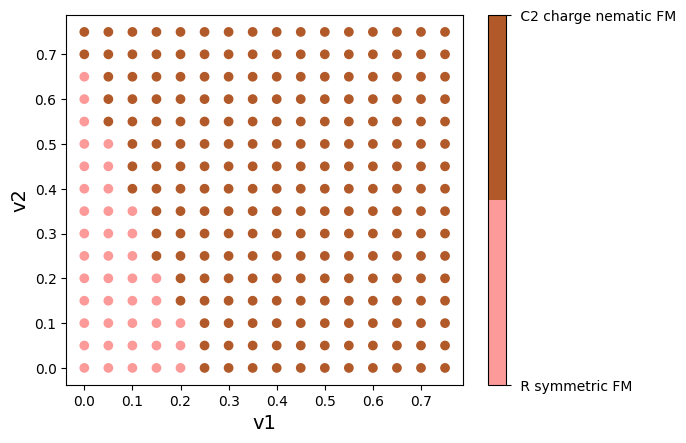

In [35]:
from matplotlib.colors import ListedColormap

paired = plt.get_cmap("Paired").colors
corlor_index = [4,11]
color_list = [paired[i] for i in corlor_index]

cmap = ListedColormap(color_list)
plt.scatter(v1_mesh, v2_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('v1', size = '14')
plt.ylabel('v2', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index_updated))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index_updated)))
cbar.set_ticklabels(unique_phase_name_updated)

# a better phase diagram

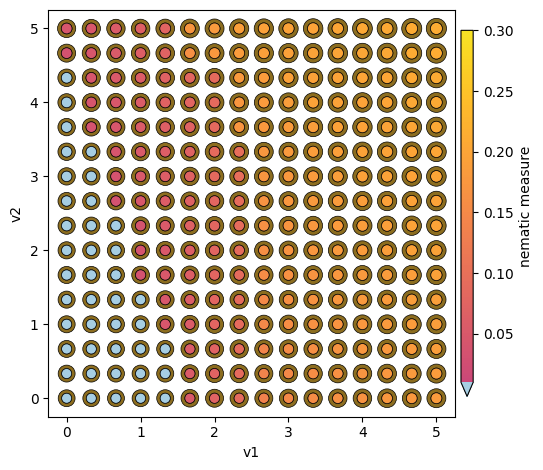

In [36]:
from functions_parameters.phase_plot import PlotConfig, plot_phase_map

ts_check = np.zeros(v1_mesh.shape)
CFG = PlotConfig(nem_vmax=0.3, energy_max=0.7)
fig, ax = plt.subplots(constrained_layout=False)
plot_phase_map(
    fig,
    ax,
    v1_mesh/0.15, v2_mesh/0.15,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_box_aspect(1)
ax.set_xlabel("v1")
ax.set_ylabel("v2")
plt.tight_layout(); plt.show()

In [37]:
np.max(nematic_measure)

np.float64(0.2117386983165344)

In [38]:
np.min(sorted_ground_state_e[:,:,0])

np.float64(-0.08650034926120713)

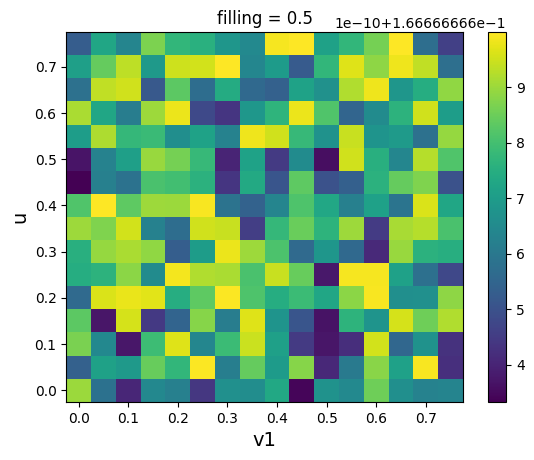

In [39]:
plt.pcolormesh(v1_mesh, v2_mesh, f_measure)
plt.colorbar()
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
plt.title('filling = 0.5')
plt.show()

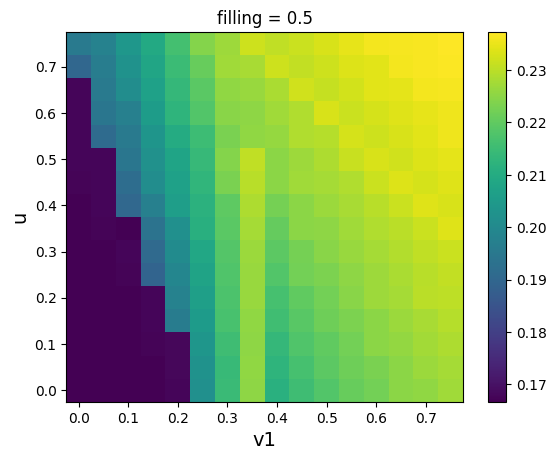

In [40]:
plt.pcolormesh(v1_mesh, v2_mesh, f_max_measure)
plt.colorbar()
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
plt.title('filling = 0.5')
plt.show()

# check the degeneracy

In [41]:
# first find if there are energy states that are highly degenerate as the known ground state while in the different phase
states_index = np.where(np.logical_and(sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]<1E-4, sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]>1E-7))
# then find out the states that are in a different phase than the known ground state
states_index_len = len(states_index[0])
degenerate_state_diagram = -np.ones(final_c_difference.shape, dtype=np.int32)
for index in range(states_index_len):
    i = states_index[0][index]
    j = states_index[1][index]
    k = states_index[2][index]
    d_ij = sorted_density[i,j,k]
    rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_ij, c_6_uc, c_3_uc, c_2_uc)
    phase_arr = np.kron(rs_recording,m_recording)
    phase = np.argmax(phase_arr)
    if phase != phase_diagram_based_on_d[i,j] and phase not in degenerate_state_diagram[i,j]:
        degenerate_state_diagram[i,j,k]=phase

In [42]:
degenerate_index = np.where(degenerate_state_diagram>0)

In [43]:
degenerate_index

(array([0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 3, 4]),
 array([12, 13, 14,  9, 10,  7,  8,  4,  5,  6,  7,  3]),
 array([4, 2, 2, 1, 1, 1, 6, 4, 6, 6, 6, 5]))

In [44]:
unique_phase_index_degenerate = np.unique(degenerate_state_diagram)
unique_phase_name_degenerate = [phase_1_1[i] for i in np.int_(unique_phase_index_degenerate) if i != -1]

In [45]:
unique_phase_name_degenerate

[' R symmetric FM', ' C2 charge nematic FM']

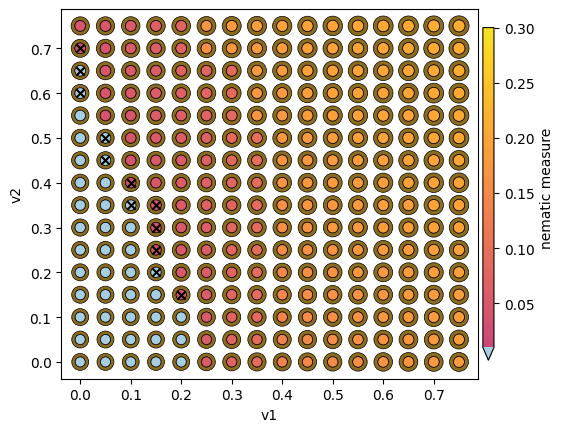

In [46]:
fig, ax = plt.subplots()
plot_phase_map(
    fig,
    ax,
    v1_mesh, v2_mesh,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.scatter(v1_arr[degenerate_index[0]], v2_arr[degenerate_index[1]], marker='x', color='black', zorder=100)